# 0. Funciones y código auxiliar


## 0.1. Instalar las bibliotecas necesarias + Hacer los imports necesarios

In [ ]:
!pip install roboflow torch torchvision opencv-python-headless
!pip install torchmetrics # Para las métricas

In [ ]:
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

## 0.2. Clase para leer las imágenes y anotaciones en formato COCO (habiendo importado el dataset de Roboflow) y reformatearlas a lo que necesita Faster R-CNN usando Pytorch

In [ ]:
import os
import torch
import torch.utils.data
from torchvision.io import read_image
from pycocotools.coco import COCO

class RoboflowCocoDataset(torch.utils.data.Dataset):
    """
    Dataset genérico para cargar datos en formato COCO (exportados de Roboflow)
    compatible con torchvision Faster R-CNN.
    """
    def __init__(self, root_dir, annotation_file, transforms=None):
        """
        Args:
            root_dir (string): Ruta al directorio que contiene las imágenes (ej. 'train/').
            annotation_file (string): Ruta al archivo .json (ej. '_annotations.coco.json').
            transforms (callable, optional): Transformaciones/Augmentations opcionales.
        """
        self.root = root_dir
        self.coco = COCO(annotation_file)
        # Obtenemos solo IDs de imágenes que tengan anotaciones (opcional, pero recomendado)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms

    def __getitem__(self, index):
        # 1. Obtener metadatos de la imagen y anotaciones
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)

        # 2. Cargar imagen
        path = coco.loadImgs(img_id)[0]['file_name']
        img_path = os.path.join(self.root, path)

        # Leemos la imagen
        img = read_image(img_path)

        # IMPORTANTE: Si la imagen es Grayscale (1 canal), convertir a RGB (3 canales)
        if img.shape[0] == 1:
             img = img.expand(3, -1, -1)

        # 3. Procesar las Bounding Boxes
        num_objs = len(coco_annotation)
        boxes = []
        labels = []

        for i in range(num_objs):
            # COCO es [xmin, ymin, width, height]
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            w = coco_annotation[i]['bbox'][2]
            h = coco_annotation[i]['bbox'][3]

            # PyTorch Faster R-CNN espera [xmin, ymin, xmax, ymax]
            xmax = xmin + w
            ymax = ymin + h

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(coco_annotation[i]['category_id'])

        # 4. Convertir todo a Tensores
        # Si no hay objetos en la imagen, crear tensores vacíos para evitar error
        if num_objs > 0:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)

        image_id = torch.tensor([img_id])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # 5. Normalizar imagen (0-255 -> 0.0-1.0)
        img = img.float() / 255.0

        # Aplicar transformaciones extra si las hubiera
        if self.transforms is not None:
            # Nota: Aplicar transforms a 'target' (cajas) requiere cuidado extra.
            # Aquí asumimos transforms solo a la imagen por simplicidad.
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

## 0.3. Configurar la red para usar el modelo "Faster R-CNN"

Usaremos un modelo pre-entrenado (ResNet50) y modificaremos la cabecera (el clasificador final) para que se ajuste a las clases de cada dataset.

Así mismo, para que no haya conflictos entre los distintos datasets, emplearemos una función que cree un modelo cada vez que vayamos a usar un dataset diferente (una instancia de la red distinta, y así mismo adaptada al número de clases de cada dataset)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_FasterRCNN_model(num_classes):
    # Cargar modelo pre-entrenado en COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # Reemplazar el predictor (cabecera) para nuestro número de clases
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

También establecemos el dispositivo donde se ejecutará el entrenamiento y la validación de los modelos (usando GPU si está disponible, o CPU en su defecto).

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## 0.4. Función de evaluación de métricas

Definiremos una función que calcula las métricas. Usaremos MeanAveragePrecision con class_metrics=True (contenida en el módulo "torchmetrics") para obtener tanto los valores del resumen global, como también el desglose por clase de las métricas más usuales en Object Detection (en este último caso, solo se empleará "mAP 50-95" por simplicidad), para que después poder comparar con YOLO. A saber:
- mAP (50-95)
- mAP (50)
- mAR (Recall)

In [ ]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm # Para la barra de progreso

def evaluate_model(model, data_loader, device, class_names=None):
    model.eval()
    metric = MeanAveragePrecision(class_metrics=True)

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluando..."):
            # Mover imágenes al dispositivo
            images = [img.to(device) for img in images]

            # Mover targets al dispositivo (son lista de diccionarios)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Obtener predicciones
            predictions = model(images)

            # Torchmetrics espera lista de dicts
            metric.update(predictions, targets)

    # Calcular métricas finales
    results = metric.compute()

    # Imprimir resumen
    print("\n" + "="*40)
    print(f"Métricas Generales:")
    print(f"mAP (50-95): {results['map']:.4f}")
    print(f"mAP (50):    {results['map_50']:.4f}")
    print(f"mAR (Recall):{results['mar_100']:.4f}") # Recall máx con 100 detecciones

    if class_names and 'map_per_class' in results:
        print("-" * 40)
        print("Desglose por Clase (mAP 50-95):")
        map_per_class = results['map_per_class']
        # mar_per_class = results['mar_100_per_class'] # Si se quiere ver recall por clase

        for i, score in enumerate(map_per_class):
            # i corresponde al índice en el tensor, hay que mapearlo con class_id
            # Ojo: Torchmetrics suele devolver índices 0,1,2... alineados con los labels presentes.
            # Asumiremos orden secuencial de etiquetas detectadas.
            c_name = class_names[i] if i < len(class_names) else f"Class {i}"
            print(f"{c_name:15s}: {score.item():.4f}")

    print("="*40 + "\n")
    return results

## 0.5. Configuración del entrenamiento (común a todos los Datasets)

Se ha seleccionado el optimizador SGD con Momentum (0.9) y Weight Decay (0.0005) siguiendo las especificaciones originales de la arquitectura Faster R-CNN (véase el paper original "Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks" https://arxiv.org/abs/1506.01497, concretamente en la sección "Training RPNs").

Aunque el paper de Faster R-CNN (Ren et al., 2015) confirma estos valores, en realidad son "heredados" de su predecesor, Fast R-CNN (Ross Girshick, 2015), y de las prácticas estándar de entrenamiento de redes como VGG y ResNet en ImageNet (véase el paper original "Fast R-CNN" https://arxiv.org/abs/1504.08083, concretamente en la sección "Fine-tuning for detection").

Aunque optimizadores adaptativos como Adam ofrecen una convergencia inicial más rápida, SGD ha demostrado históricamente ofrecer una mayor capacidad de generalización y estabilidad en tareas de Object Detection al realizar fine-tuning sobre redes pre-entrenadas como ResNet (a la vista está que era el estándar de facto empleado en los artículos originales tanto de Faster R-CNN como de Fast R-CNN).

In [ ]:
# Optimizador
#params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

El número de épocas empleado (10) se tomó en consideración con el empleado también en las diferentes versiones estudiadas de YOLO, para poder hacer la comparación, así como debido al excesivo tiempo necesario para entrenar este modelo frente a YOLO.

In [ ]:
# Número de épocas
num_epochs = 10

# 1. Dataset ROSAS

https://universe.roboflow.com/germanrv/rose-leaf-diseases-gboa4

## 1.1. Dataset ROSAS (SIN DataAugmentation)

Emplearemos el dataset https://universe.roboflow.com/germanrv/rose-leaf-diseases-gboa4 en su versión "V2_NoDataAug"

### 1. Carga del dataset desde Roboflow + Preparación de los dataloaders

In [ ]:
from roboflow import Roboflow

# 1. Inicializar Roboflow con la API
rf = Roboflow(api_key="aipZ4cUXzfPSqQnBRokr")

# 2. Acceder al proyecto y descargar la versión v4 (V2_NoDataAug - sin data augmentation)
project = rf.workspace("germanrv").project("rose-leaf-diseases-gboa4")
version = project.version(4)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


Como se verá más adelante para el entrenamiento, cargaremos los datasets de entrenamiento y validación por separado, pues en la implementación considerada no fue posible replicar del todo el flujo de trabajo en Fastai (como en la práctica 2, donde en el dataloader podíamos elegir el porcentaje del dataset de entrenamiento que se emplearía para validar y usando la función "fit" o "fit_one_cycle" para entrenar sobre el dataloader ya preparado), siendo necesario en este caso, en el entrenamiento, separar en cada época la fase de entrenamiento (actualizando pesos) y la fase de validación (evaluando el modelo en el conjunto de validación pero SIN ACTUALIZAR PESOS).

In [ ]:
# Rutas a los datos descargados
train_dir_Rosas = "/content/rose-leaf-diseases-4/train"
train_ann_Rosas = "/content/rose-leaf-diseases-4/train/_annotations.coco.json"
valid_dir_Rosas = "/content/rose-leaf-diseases-4/valid"
valid_ann_Rosas = "/content/rose-leaf-diseases-4/valid/_annotations.coco.json"

# Cargar datasets y dataloaders (para ENTRENAMIENTO)
dataset_train_Rosas = RoboflowCocoDataset(train_dir_Rosas, train_ann_Rosas)
dataset_valid_Rosas = RoboflowCocoDataset(valid_dir_Rosas, valid_ann_Rosas)

train_loader_Rosas = torch.utils.data.DataLoader(
    dataset_train_Rosas,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)
valid_loader_Rosas = torch.utils.data.DataLoader(
    dataset_valid_Rosas,
    batch_size=32,        # TRUCO: Es posible usar el DOBLE de batch_size que en train porque validar consume mucha menos memoria (no hay backprop).
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Inspeccionamos las clases resultantes en el dataset (pues esta información será necesaria para luego configurar adecuadamente la red).

Como era de esperar, en este formato, se pueden observar las 3 clases que se quieren detectar ("EarlyBlight", "Tomato healthy" y "lateBlight"), así como una cuarta clase ("tomatoes-and-leaves") referente al Background (el fondo).

In [ ]:
# Acceder al objeto COCO interno
coco_Rosas = dataset_train_Rosas.coco

# Obtener los IDs de las categorías y cargar su información
cat_ids_Rosas = coco_Rosas.getCatIds()
categories_Rosas = coco_Rosas.loadCats(cat_ids_Rosas)

# 4. Imprimir los resultados
print(f"Total de clases encontradas en el JSON: {len(categories_Rosas)}")
print("-" * 30)
for cat in categories_Rosas:
    print(f"ID: {cat['id']} - Nombre: {cat['name']}")

print("-" * 30)

Total de clases encontradas en el JSON: 5
------------------------------
ID: 0 - Nombre: rose-leaf-diseases
ID: 1 - Nombre: Black Spot
ID: 2 - Nombre: Downy Mildew
ID: 3 - Nombre: Normal
ID: 4 - Nombre: Powdery Mildew
------------------------------


Así mismo, verificamos que el número de imagenes coincide con el esperado (el que aparecía en Roboflow)

In [ ]:
import glob

# Contar solo imágenes JPG
num_imagenes_train = len(glob.glob(os.path.join(train_dir_Rosas, "*.jpg")))
num_imagenes_valid = len(glob.glob(os.path.join(valid_dir_Rosas, "*.jpg")))

print(f"Imágenes de entrenamiento: {num_imagenes_train}")
print(f"Imágenes de validación: {num_imagenes_valid}")

Imágenes de entrenamiento: 1656
Imágenes de validación: 534


### 2. Entrenamiento

Antes de proceder al entrenamiento en sí, por seguridad, comprobamos que efectivamente se está haciendo uso de la GPU (para que el entrenamiento no se haga excesivamente largo)

In [ ]:
import torch
print(f"Torh ve la GPU: {torch.cuda.is_available()}")
print(f"Nombre: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Torh ve la GPU: True
Nombre: Tesla T4


NOTA: Es importante en el paso anterior haber revisado explícitamente el dataset para ver cuántas clases había (num_classes).

Empezamos por instanciar una modelo "Faster R-CNN" adaptado al dataset de las Rosas (teniendo en cuenta el número de clases a detectar, para formar la cabecera correspondiente), así como enviar dicho modelo al dispositivo detectado (GPU o CPU)

In [ ]:
num_classes_Rosas = 5
modelo_Rosas = get_FasterRCNN_model(num_classes_Rosas)
modelo_Rosas.to(device);

Empleamos el optimizador (como ya se comentó anteriormente, común a los diferentes datasets empleados) pero adaptado al modelo instanciado para este dataset

In [ ]:
params_Rosas = [p for p in modelo_Rosas.parameters() if p.requires_grad]
optimizer_Rosas = torch.optim.SGD(params_Rosas, lr=0.005, momentum=0.9, weight_decay=0.0005)

A continuación pasamos a entrenar, guardando el modelo final (con los pesos actualizados tras completar el entrenamiento) y mostrando la función de pérdida.

Nota 1: Como evaluar las métricas mAP es lento, por conveniencia lo haremos solo al final, para no ralentizar en exceso el entrenamiento (que ya de por sí Faster R-CNN suele tardar más que YOLO).

Nota 2: Para poder replicar el flujo de trabajo clásico de Fastai (tal y como ya se hizo en la práctica 2 de esta asignatura), entrenando con un conjunto de entrenamiento y, al final de cada época, calcular la pérdida en el conjunto de validación (sin entrenar sobre él) para ver las dos curvas juntas, fue necesario envolver la fase de evaluación del modelo sobre el conjunto de validación con "torch.no_grad()" (que simplemente congela los gradientes - i.e. no se actualizan - de modo que esas evaluaciones en validación no son consideradas a efectos de aprender sobre esos ejemplos).

In [ ]:
train_loss_history = []
val_loss_history = []

# Instante inicial (para calcular la duración del entrenamiento)
start_time = time.time()

print(f"(Rosas) Iniciando entrenamiento...")

for epoch in range(num_epochs):
    # -------------------------
    # 1. FASE DE ENTRENAMIENTO
    # -------------------------
    modelo_Rosas.train() # Habilita cálculo de loss y actualización de BN/Dropout
    train_epoch_loss = 0
    train_count = 0

    # Barra de progreso para Train
    pbar = tqdm(train_loader_Rosas, desc=f"Época {epoch+1}/{num_epochs} [Train]")

    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass y cálculo de pérdida
        loss_dict = modelo_Rosas(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backprop
        optimizer_Rosas.zero_grad()
        losses.backward()
        optimizer_Rosas.step()

        # Acumular loss
        loss_value = losses.item()
        train_epoch_loss += loss_value
        train_count += 1
        pbar.set_postfix({'loss': loss_value})

    avg_train_loss = train_epoch_loss / train_count
    train_loss_history.append(avg_train_loss)

    # -------------------------
    # 2. FASE DE VALIDACIÓN
    # -------------------------
    # NOTA IMPORTANTE: Mantenemos model.train() para obtener Losses,
    # pero usamos torch.no_grad() para NO entrenar.

    val_epoch_loss = 0
    val_count = 0

    with torch.no_grad(): # Congelamos gradientes
        # No hace falta barra de progreso aquí normalmente, es rápido
        for images, targets in valid_loader_Rosas:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Al estar en model.train() (aunque sin gradientes), nos devuelve losses
            loss_dict = modelo_Rosas(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            val_epoch_loss += losses.item()
            val_count += 1

    avg_val_loss = val_epoch_loss / val_count
    val_loss_history.append(avg_val_loss)

    print(f"--> Fin Época {epoch+1} | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_val_loss:.4f}")

    # Guardar el mejor modelo basado en valid loss (checkpointing básico)
    if epoch > 0 and avg_val_loss < min(val_loss_history[:-1]):
        torch.save(modelo_Rosas.state_dict(), "best_model_tomatoes.pth")

print("(Rosas) Entrenamiento completado.")

end_time = time.time() # Instante final (para calcular duración entrenamiento)

(Rosas) Iniciando entrenamiento...


Época 1/10 [Train]: 100%|██████████| 104/104 [04:28<00:00,  2.58s/it, loss=0.272]


--> Fin Época 1 | Train Loss: 0.4773 | Valid Loss: 0.3021


Época 2/10 [Train]: 100%|██████████| 104/104 [05:06<00:00,  2.95s/it, loss=0.264]


--> Fin Época 2 | Train Loss: 0.2789 | Valid Loss: 0.2583


Época 3/10 [Train]: 100%|██████████| 104/104 [05:06<00:00,  2.95s/it, loss=0.0878]


--> Fin Época 3 | Train Loss: 0.2451 | Valid Loss: 0.2611


Época 4/10 [Train]: 100%|██████████| 104/104 [05:07<00:00,  2.95s/it, loss=0.21]


--> Fin Época 4 | Train Loss: 0.2288 | Valid Loss: 0.2732


Época 5/10 [Train]: 100%|██████████| 104/104 [05:07<00:00,  2.96s/it, loss=0.168]


--> Fin Época 5 | Train Loss: 0.2156 | Valid Loss: 0.2533


Época 6/10 [Train]: 100%|██████████| 104/104 [05:07<00:00,  2.95s/it, loss=0.156]


--> Fin Época 6 | Train Loss: 0.2050 | Valid Loss: 0.2598


Época 7/10 [Train]: 100%|██████████| 104/104 [05:07<00:00,  2.96s/it, loss=0.409]


--> Fin Época 7 | Train Loss: 0.1932 | Valid Loss: 0.2533


Época 8/10 [Train]: 100%|██████████| 104/104 [05:07<00:00,  2.96s/it, loss=0.24]


--> Fin Época 8 | Train Loss: 0.1882 | Valid Loss: 0.2598


Época 9/10 [Train]: 100%|██████████| 104/104 [05:07<00:00,  2.96s/it, loss=0.152]


--> Fin Época 9 | Train Loss: 0.1781 | Valid Loss: 0.2736


Época 10/10 [Train]: 100%|██████████| 104/104 [05:07<00:00,  2.95s/it, loss=0.214]


--> Fin Época 10 | Train Loss: 0.1693 | Valid Loss: 0.2768
(Rosas) Entrenamiento completado.


In [ ]:
# Duración del entrenamiento
total_seconds = end_time - start_time
total_minutes = total_seconds / 60
total_hours = total_seconds / 3600

print(f"Tiempo Total de Entrenamiento (Rosas): {total_seconds:.2f} segundos")
print(f"\tEquivalente a: {total_minutes:.2f} minutos")

Tiempo Total de Entrenamiento (Rosas): 3442.49 segundos
	Equivalente a: 57.37 minutos


### 3. Validación (sobre el conjunto de test)

Primero, empezamos por mostrar la evolución de la función de pérdida durante el entrenamiento (para los conjuntos de entrenamiento y validación, respectivamente)

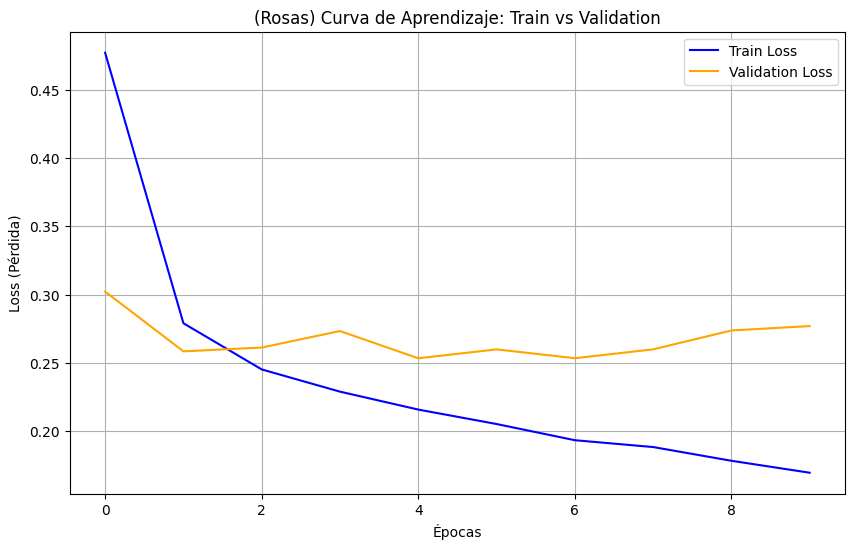

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.xlabel('Épocas')
plt.ylabel('Loss (Pérdida)')
plt.title('(Rosas) Curva de Aprendizaje: Train vs Validation')
plt.legend()
plt.grid(True)
plt.show()

A continuación, aplicamos inferencia sobre los conjuntos de entrenamiento y de test (i.e. fuera de la muestra), y calculamos el valor de las métricas en cada uno.

In [ ]:
# 1. Definir ruta al conjunto de test
test_dir_Rosas = "/content/rose-leaf-diseases-4/test"
test_ann_Rosas = "/content/rose-leaf-diseases-4/test/_annotations.coco.json"

# 2. Crear Dataset y DataLoader de Test
dataset_test_Rosas = RoboflowCocoDataset(test_dir_Rosas, test_ann_Rosas)
test_loader_Rosas = torch.utils.data.DataLoader(
    dataset_test_Rosas,
    batch_size=32,  # Igual que en el conjunto de evaluacion, puede ser el doble que en entrenamiento, porque no hay backprop
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

# 3. Lista de nombres de clases para el reporte (excluyendo background id 0)
mis_clases = ["Black Spot", "Downy Mildew", "Normal", "Powdery Mildew"]

# Ver los resultados en TRAIN y en TEST para ver si hay overfitting
print("\n--- TRAIN ---")
metrics_train = evaluate_model(modelo_Rosas, train_loader_Rosas, device, class_names=mis_clases)

print("\n--- TEST ---")
metrics_test = evaluate_model(modelo_Rosas, test_loader_Rosas, device, class_names=mis_clases)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

--- TRAIN ---


Evaluando...: 100%|██████████| 104/104 [02:05<00:00,  1.21s/it]



Métricas Generales:
mAP (50-95): 0.5935
mAP (50):    0.9698
mAR (Recall):0.6688
----------------------------------------
Desglose por Clase (mAP 50-95):
Black Spot     : 0.7581
Downy Mildew   : 0.5142
Normal         : 0.5110
Powdery Mildew : 0.5907


--- TEST ---


Evaluando...: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it]



Métricas Generales:
mAP (50-95): 0.4477
mAP (50):    0.8517
mAR (Recall):0.5363
----------------------------------------
Desglose por Clase (mAP 50-95):
Black Spot     : 0.5952
Downy Mildew   : 0.4454
Normal         : 0.4728
Powdery Mildew : 0.2771



## 1.2. Dataset ROSAS (CON DataAugmentation)

Emplearemos el dataset https://universe.roboflow.com/germanrv/rose-leaf-diseases-gboa4 en su versión "V2_DataAug"

### 1. Carga del dataset desde Roboflow + Preparación de los dataloaders

In [ ]:
from roboflow import Roboflow

# 1. Inicializar Roboflow con la API
rf = Roboflow(api_key="aipZ4cUXzfPSqQnBRokr")

# 2. Acceder al proyecto y descargar la versión v4 (V2_NoDataAug - sin data augmentation)
project = rf.workspace("germanrv").project("rose-leaf-diseases-gboa4")
version = project.version(3)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to rose-leaf-diseases-3 in coco:: 100%|██████████| 6045/6045 [00:01<00:00, 5901.83it/s]


In [ ]:
# Rutas a los datos descargados
train_dir_Rosas_DataAug = "/content/rose-leaf-diseases-3/train"
train_ann_Rosas_DataAug = "/content/rose-leaf-diseases-3/train/_annotations.coco.json"
valid_dir_Rosas_DataAug = "/content/rose-leaf-diseases-3/valid"
valid_ann_Rosas_DataAug = "/content/rose-leaf-diseases-3/valid/_annotations.coco.json"

# Cargar datasets y dataloaders (para ENTRENAMIENTO)
dataset_train_Rosas_DataAug = RoboflowCocoDataset(train_dir_Rosas_DataAug, train_ann_Rosas_DataAug)
dataset_valid_Rosas_DataAug = RoboflowCocoDataset(valid_dir_Rosas_DataAug, valid_ann_Rosas_DataAug)

train_loader_Rosas_DataAug = torch.utils.data.DataLoader(
    dataset_train_Rosas_DataAug,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)
valid_loader_Rosas_DataAug = torch.utils.data.DataLoader(
    dataset_valid_Rosas_DataAug,
    batch_size=32,        # TRUCO: Es posible usar el DOBLE de batch_size que en train porque validar consume mucha menos memoria (no hay backprop).
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Acceder al objeto COCO interno
coco_Rosas_DataAug = dataset_train_Rosas_DataAug.coco

# Obtener los IDs de las categorías y cargar su información
cat_ids_Rosas_DataAug = coco_Rosas_DataAug.getCatIds()
categories_Rosas_DataAug = coco_Rosas_DataAug.loadCats(cat_ids_Rosas_DataAug)

# 4. Imprimir los resultados
print(f"Total de clases encontradas en el JSON: {len(categories_Rosas_DataAug)}")
print("-" * 30)
for cat in categories_Rosas_DataAug:
    print(f"ID: {cat['id']} - Nombre: {cat['name']}")

print("-" * 30)

Total de clases encontradas en el JSON: 5
------------------------------
ID: 0 - Nombre: rose-leaf-diseases
ID: 1 - Nombre: Black Spot
ID: 2 - Nombre: Downy Mildew
ID: 3 - Nombre: Normal
ID: 4 - Nombre: Powdery Mildew
------------------------------


In [ ]:
import glob

# Contar solo imágenes JPG
num_imagenes_train = len(glob.glob(os.path.join(train_dir_Rosas_DataAug, "*.jpg")))
num_imagenes_valid = len(glob.glob(os.path.join(valid_dir_Rosas_DataAug, "*.jpg")))

print(f"Imágenes de entrenamiento: {num_imagenes_train}")
print(f"Imágenes de validación: {num_imagenes_valid}")

Imágenes de entrenamiento: 4968
Imágenes de validación: 534


### 2. Entrenamiento

In [ ]:
import torch
print(f"Torch ve la GPU: {torch.cuda.is_available()}")
print(f"Nombre: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Torch ve la GPU: True
Nombre: Tesla T4


In [ ]:
num_classes_Rosas_DataAug = 5
modelo_Rosas_DataAug = get_FasterRCNN_model(num_classes_Rosas_DataAug)
modelo_Rosas_DataAug.to(device);

In [ ]:
params_Rosas_DataAug = [p for p in modelo_Rosas_DataAug.parameters() if p.requires_grad]
optimizer_Rosas_DataAug = torch.optim.SGD(params_Rosas_DataAug, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
train_loss_history = []
val_loss_history = []

# Instante inicial (para calcular la duración del entrenamiento)
start_time = time.time()

print(f"(Rosas CON DataAug) Iniciando entrenamiento...")

for epoch in range(num_epochs):
    # -------------------------
    # 1. FASE DE ENTRENAMIENTO
    # -------------------------
    modelo_Rosas_DataAug.train() # Habilita cálculo de loss y actualización de BN/Dropout
    train_epoch_loss = 0
    train_count = 0

    # Barra de progreso para Train
    pbar = tqdm(train_loader_Rosas_DataAug, desc=f"Época {epoch+1}/{num_epochs} [Train]")

    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass y cálculo de pérdida
        loss_dict = modelo_Rosas_DataAug(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backprop
        optimizer_Rosas_DataAug.zero_grad()
        losses.backward()
        optimizer_Rosas_DataAug.step()

        # Acumular loss
        loss_value = losses.item()
        train_epoch_loss += loss_value
        train_count += 1
        pbar.set_postfix({'loss': loss_value})

    avg_train_loss = train_epoch_loss / train_count
    train_loss_history.append(avg_train_loss)

    # -------------------------
    # 2. FASE DE VALIDACIÓN
    # -------------------------
    # NOTA IMPORTANTE: Mantenemos model.train() para obtener Losses,
    # pero usamos torch.no_grad() para NO entrenar.

    val_epoch_loss = 0
    val_count = 0

    with torch.no_grad(): # Congelamos gradientes
        # No hace falta barra de progreso aquí normalmente, es rápido
        for images, targets in valid_loader_Rosas_DataAug:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Al estar en model.train() (aunque sin gradientes), nos devuelve losses
            loss_dict = modelo_Rosas_DataAug(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            val_epoch_loss += losses.item()
            val_count += 1

    avg_val_loss = val_epoch_loss / val_count
    val_loss_history.append(avg_val_loss)

    print(f"--> Fin Época {epoch+1} | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_val_loss:.4f}")

    # Guardar el mejor modelo basado en valid loss (checkpointing básico)
    if epoch > 0 and avg_val_loss < min(val_loss_history[:-1]):
        torch.save(modelo_Rosas_DataAug.state_dict(), "best_model_tomatoes.pth")

print("(Rosas CON DataAug) Entrenamiento completado.")

end_time = time.time() # Instante final (para calcular duración entrenamiento)

(Rosas CON DataAug) Iniciando entrenamiento...


Época 1/10 [Train]: 100%|██████████| 311/311 [15:20<00:00,  2.96s/it, loss=0.296]


--> Fin Época 1 | Train Loss: 0.3441 | Valid Loss: 0.2546


Época 2/10 [Train]: 100%|██████████| 311/311 [15:20<00:00,  2.96s/it, loss=0.354]


--> Fin Época 2 | Train Loss: 0.2556 | Valid Loss: 0.2467


Época 3/10 [Train]: 100%|██████████| 311/311 [15:20<00:00,  2.96s/it, loss=0.208]


--> Fin Época 3 | Train Loss: 0.2377 | Valid Loss: 0.2426


Época 4/10 [Train]: 100%|██████████| 311/311 [15:19<00:00,  2.96s/it, loss=0.208]


--> Fin Época 4 | Train Loss: 0.2263 | Valid Loss: 0.2449


Época 5/10 [Train]: 100%|██████████| 311/311 [15:20<00:00,  2.96s/it, loss=0.209]


--> Fin Época 5 | Train Loss: 0.2166 | Valid Loss: 0.2464


Época 6/10 [Train]: 100%|██████████| 311/311 [15:19<00:00,  2.96s/it, loss=0.101]


--> Fin Época 6 | Train Loss: 0.2068 | Valid Loss: 0.2586


Época 7/10 [Train]: 100%|██████████| 311/311 [15:20<00:00,  2.96s/it, loss=0.148]


--> Fin Época 7 | Train Loss: 0.2005 | Valid Loss: 0.2436


Época 8/10 [Train]: 100%|██████████| 311/311 [15:20<00:00,  2.96s/it, loss=0.304]


--> Fin Época 8 | Train Loss: 0.1893 | Valid Loss: 0.2616


Época 9/10 [Train]: 100%|██████████| 311/311 [15:21<00:00,  2.96s/it, loss=0.146]


--> Fin Época 9 | Train Loss: 0.1856 | Valid Loss: 0.2513


Época 10/10 [Train]: 100%|██████████| 311/311 [15:21<00:00,  2.96s/it, loss=0.0799]


--> Fin Época 10 | Train Loss: 0.1757 | Valid Loss: 0.2606
(Rosas CON DataAug) Entrenamiento completado.


In [ ]:
# Duración del entrenamiento
total_seconds = end_time - start_time
total_minutes = total_seconds / 60
total_hours = total_seconds / 3600

print(f"Tiempo Total de Entrenamiento (Rosas - CON DataAug): {total_seconds:.2f} segundos")
print(f"\tEquivalente a: {total_minutes:.2f} minutos")
print(f"\tEquivalente a: {total_hours:.2f} horas")

Tiempo Total de Entrenamiento (Rosas - CON DataAug): 9613.72 segundos
	Equivalente a: 160.23 minutos
	Equivalente a: 2.67 horas


### 3. Validación (sobre el conjunto de test)

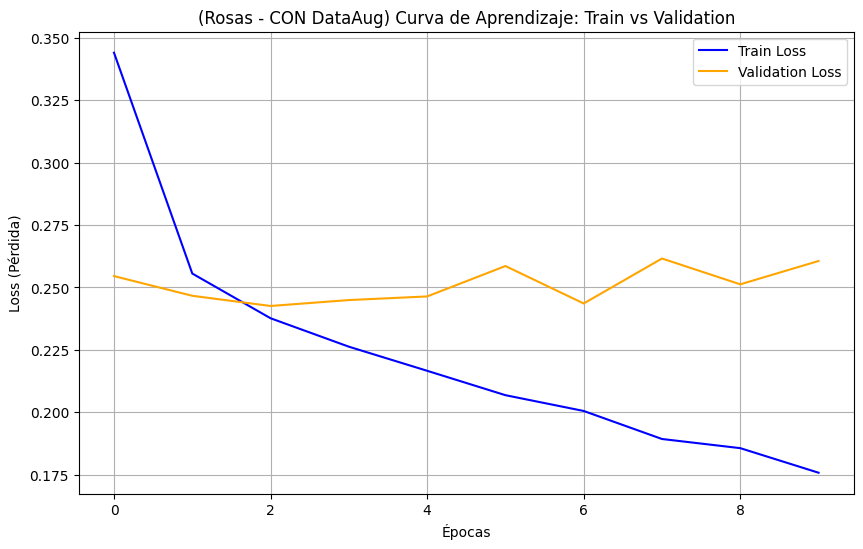

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.xlabel('Épocas')
plt.ylabel('Loss (Pérdida)')
plt.title('(Rosas - CON DataAug) Curva de Aprendizaje: Train vs Validation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 1. Definir ruta al conjunto de test
test_dir_Rosas_DataAug = "/content/rose-leaf-diseases-3/test"
test_ann_Rosas_DataAug = "/content/rose-leaf-diseases-3/test/_annotations.coco.json"

# 2. Crear Dataset y DataLoader de Test
dataset_test_Rosas_DataAug = RoboflowCocoDataset(test_dir_Rosas_DataAug, test_ann_Rosas_DataAug)
test_loader_Rosas_DataAug = torch.utils.data.DataLoader(
    dataset_test_Rosas_DataAug,
    batch_size=32,  # Igual que en el conjunto de evaluacion, puede ser el doble que en entrenamiento, porque no hay backprop
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

# 3. Lista de nombres de clases para el reporte (excluyendo background id 0)
mis_clases = ["Black Spot", "Downy Mildew", "Normal", "Powdery Mildew"]

# Ver los resultados en TRAIN y en TEST para ver si hay overfitting
print("\n--- TRAIN (Rosas CON DataAug) ---")
metrics_train = evaluate_model(modelo_Rosas_DataAug, train_loader_Rosas_DataAug, device, class_names=mis_clases)

print("\n--- TEST (Rosas CON DataAug) ---")
metrics_test = evaluate_model(modelo_Rosas_DataAug, test_loader_Rosas_DataAug, device, class_names=mis_clases)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

--- TRAIN (Rosas CON DataAug) ---


Evaluando...: 100%|██████████| 311/311 [06:14<00:00,  1.20s/it]



Métricas Generales:
mAP (50-95): 0.5778
mAP (50):    0.9648
mAR (Recall):0.6600
----------------------------------------
Desglose por Clase (mAP 50-95):
Black Spot     : 0.7429
Downy Mildew   : 0.5290
Normal         : 0.4685
Powdery Mildew : 0.5708


--- TEST (Rosas CON DataAug) ---


Evaluando...: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]



Métricas Generales:
mAP (50-95): 0.4535
mAP (50):    0.8568
mAR (Recall):0.5455
----------------------------------------
Desglose por Clase (mAP 50-95):
Black Spot     : 0.6012
Downy Mildew   : 0.4382
Normal         : 0.4677
Powdery Mildew : 0.3070



# 2. Dataset PATATAS

https://universe.roboflow.com/germanrv/potatoes_leaf-diseases

## 2.1. Dataset PATATAS (SIN DataAugmentation)

Emplearemos el dataset https://universe.roboflow.com/germanrv/potatoes_leaf-diseases en su versión "V2_NoDataAug"

### 1. Carga del dataset desde Roboflow + Preparación de los dataloaders

In [ ]:
from roboflow import Roboflow

# 1. Inicializar Roboflow con la API
rf = Roboflow(api_key="aipZ4cUXzfPSqQnBRokr")

# 2. Acceder al proyecto y descargar la versión v4 (V2_NoDataAug - sin data augmentation)
project = rf.workspace("germanrv").project("potatoes_leaf-diseases")
version = project.version(4)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
# Rutas a los datos descargados
train_dir_Patatas = "/content/Potatoes_leaf-diseases-4/train"
train_ann_Patatas = "/content/Potatoes_leaf-diseases-4/train/_annotations.coco.json"
valid_dir_Patatas = "/content/Potatoes_leaf-diseases-4/valid"
valid_ann_Patatas = "/content/Potatoes_leaf-diseases-4/valid/_annotations.coco.json"

# Cargar datasets y dataloaders (para ENTRENAMIENTO)
dataset_train_Patatas = RoboflowCocoDataset(train_dir_Patatas, train_ann_Patatas)
dataset_valid_Patatas = RoboflowCocoDataset(valid_dir_Patatas, valid_ann_Patatas)

train_loader_Patatas = torch.utils.data.DataLoader(
    dataset_train_Patatas,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)
valid_loader_Patatas = torch.utils.data.DataLoader(
    dataset_valid_Patatas,
    batch_size=32,        # TRUCO: Es posible usar el DOBLE de batch_size que en train porque validar consume mucha menos memoria (no hay backprop).
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Acceder al objeto COCO interno
coco_Patatas = dataset_train_Patatas.coco

# Obtener los IDs de las categorías y cargar su información
cat_ids_Patatas = coco_Patatas.getCatIds()
categories_Patatas = coco_Patatas.loadCats(cat_ids_Patatas)

# 4. Imprimir los resultados
print(f"Total de clases encontradas en el JSON: {len(categories_Patatas)}")
print("-" * 30)
for cat in categories_Patatas:
    print(f"ID: {cat['id']} - Nombre: {cat['name']}")

print("-" * 30)

Total de clases encontradas en el JSON: 4
------------------------------
ID: 0 - Nombre: potatoes-leaf
ID: 1 - Nombre: early bright
ID: 2 - Nombre: healthy
ID: 3 - Nombre: late bright
------------------------------


In [ ]:
import glob

# Contar solo imágenes JPG
num_imagenes_train = len(glob.glob(os.path.join(train_dir_Patatas, "*.jpg")))
num_imagenes_valid = len(glob.glob(os.path.join(valid_dir_Patatas, "*.jpg")))

print(f"Imágenes de entrenamiento: {num_imagenes_train}")
print(f"Imágenes de validación: {num_imagenes_valid}")

Imágenes de entrenamiento: 613
Imágenes de validación: 101


### 2. Entrenamiento

In [ ]:
import torch
print(f"Torch ve la GPU: {torch.cuda.is_available()}")
print(f"Nombre: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Torch ve la GPU: True
Nombre: Tesla T4


In [ ]:
num_classes_Patatas = 4
modelo_Patatas = get_FasterRCNN_model(num_classes_Patatas)
modelo_Patatas.to(device);

In [ ]:
params_Patatas = [p for p in modelo_Patatas.parameters() if p.requires_grad]
optimizer_Patatas = torch.optim.SGD(params_Patatas, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
train_loss_history = []
val_loss_history = []

# Instante inicial (para calcular la duración del entrenamiento)
start_time = time.time()

print(f"(Patatas) Iniciando entrenamiento...")

for epoch in range(num_epochs):
    # -------------------------
    # 1. FASE DE ENTRENAMIENTO
    # -------------------------
    modelo_Patatas.train() # Habilita cálculo de loss y actualización de BN/Dropout
    train_epoch_loss = 0
    train_count = 0

    # Barra de progreso para Train
    pbar = tqdm(train_loader_Patatas, desc=f"Época {epoch+1}/{num_epochs} [Train]")

    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass y cálculo de pérdida
        loss_dict = modelo_Patatas(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backprop
        optimizer_Patatas.zero_grad()
        losses.backward()
        optimizer_Patatas.step()

        # Acumular loss
        loss_value = losses.item()
        train_epoch_loss += loss_value
        train_count += 1
        pbar.set_postfix({'loss': loss_value})

    avg_train_loss = train_epoch_loss / train_count
    train_loss_history.append(avg_train_loss)

    # -------------------------
    # 2. FASE DE VALIDACIÓN
    # -------------------------
    # NOTA IMPORTANTE: Mantenemos model.train() para obtener Losses,
    # pero usamos torch.no_grad() para NO entrenar.

    val_epoch_loss = 0
    val_count = 0

    with torch.no_grad(): # Congelamos gradientes
        # No hace falta barra de progreso aquí normalmente, es rápido
        for images, targets in valid_loader_Patatas:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Al estar en model.train() (aunque sin gradientes), nos devuelve losses
            loss_dict = modelo_Patatas(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            val_epoch_loss += losses.item()
            val_count += 1

    avg_val_loss = val_epoch_loss / val_count
    val_loss_history.append(avg_val_loss)

    print(f"--> Fin Época {epoch+1} | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_val_loss:.4f}")

    # Guardar el mejor modelo basado en valid loss (checkpointing básico)
    if epoch > 0 and avg_val_loss < min(val_loss_history[:-1]):
        torch.save(modelo_Patatas.state_dict(), "best_model_patatas.pth")

print("(Patatas) Entrenamiento completado.")

end_time = time.time() # Instante final (para calcular duración entrenamiento)

(Patatas) Iniciando entrenamiento...


Época 1/10 [Train]: 100%|██████████| 39/39 [01:53<00:00,  2.90s/it, loss=0.671]


--> Fin Época 1 | Train Loss: 0.8069 | Valid Loss: 0.3813


Época 2/10 [Train]: 100%|██████████| 39/39 [01:53<00:00,  2.91s/it, loss=0.517]


--> Fin Época 2 | Train Loss: 0.5303 | Valid Loss: 0.3066


Época 3/10 [Train]: 100%|██████████| 39/39 [01:53<00:00,  2.91s/it, loss=0.305]


--> Fin Época 3 | Train Loss: 0.4678 | Valid Loss: 0.2686


Época 4/10 [Train]: 100%|██████████| 39/39 [01:53<00:00,  2.91s/it, loss=0.271]


--> Fin Época 4 | Train Loss: 0.4309 | Valid Loss: 0.2533


Época 5/10 [Train]: 100%|██████████| 39/39 [01:53<00:00,  2.91s/it, loss=0.436]


--> Fin Época 5 | Train Loss: 0.4140 | Valid Loss: 0.2427


Época 6/10 [Train]: 100%|██████████| 39/39 [01:53<00:00,  2.91s/it, loss=0.73]


--> Fin Época 6 | Train Loss: 0.3953 | Valid Loss: 0.2485


Época 7/10 [Train]: 100%|██████████| 39/39 [01:53<00:00,  2.92s/it, loss=0.215]


--> Fin Época 7 | Train Loss: 0.3764 | Valid Loss: 0.2408


Época 8/10 [Train]: 100%|██████████| 39/39 [01:53<00:00,  2.92s/it, loss=0.301]


--> Fin Época 8 | Train Loss: 0.3608 | Valid Loss: 0.2452


Época 9/10 [Train]: 100%|██████████| 39/39 [01:53<00:00,  2.92s/it, loss=0.186]


--> Fin Época 9 | Train Loss: 0.3421 | Valid Loss: 0.2533


Época 10/10 [Train]: 100%|██████████| 39/39 [01:53<00:00,  2.91s/it, loss=0.253]


--> Fin Época 10 | Train Loss: 0.3280 | Valid Loss: 0.2449
(Patatas) Entrenamiento completado.


In [ ]:
# Duración del entrenamiento
total_seconds = end_time - start_time
total_minutes = total_seconds / 60
total_hours = total_seconds / 3600

print(f"Tiempo Total de Entrenamiento (Patatas): {total_seconds:.2f} segundos")
print(f"\tEquivalente a: {total_minutes:.2f} minutos")

Tiempo Total de Entrenamiento (Patatas): 1217.38 segundos
	Equivalente a: 20.29 minutos


### 3. Validación (sobre el conjunto de test)

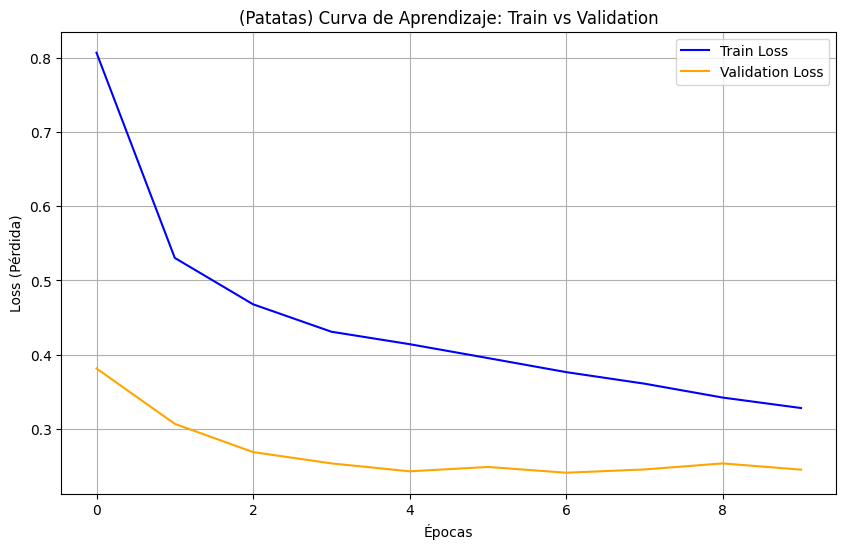

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.xlabel('Épocas')
plt.ylabel('Loss (Pérdida)')
plt.title('(Patatas) Curva de Aprendizaje: Train vs Validation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 1. Definir ruta al conjunto de test
test_dir_Patatas = "/content/Potatoes_leaf-diseases-4/test"
test_ann_Patatas = "/content/Potatoes_leaf-diseases-4/test/_annotations.coco.json"

# 2. Crear Dataset y DataLoader de Test
dataset_test_Patatas = RoboflowCocoDataset(test_dir_Patatas, test_ann_Patatas)
test_loader_Patatas = torch.utils.data.DataLoader(
    dataset_test_Patatas,
    batch_size=32,  # Igual que en el conjunto de evaluacion, puede ser el doble que en entrenamiento, porque no hay backprop
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

# 3. Lista de nombres de clases para el reporte (excluyendo background id 0)
mis_clases = ["early bright", "healthy", "late bright"]

# Ver los resultados en TRAIN y en TEST para ver si hay overfitting
print("\n--- TRAIN ---")
metrics_train = evaluate_model(modelo_Patatas, train_loader_Patatas, device, class_names=mis_clases)

print("\n--- TEST ---")
metrics_test = evaluate_model(modelo_Patatas, test_loader_Patatas, device, class_names=mis_clases)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

--- TRAIN ---


Evaluando...: 100%|██████████| 39/39 [00:46<00:00,  1.18s/it]



Métricas Generales:
mAP (50-95): 0.6400
mAP (50):    0.8735
mAR (Recall):0.7414
----------------------------------------
Desglose por Clase (mAP 50-95):
early bright   : 0.5318
healthy        : 0.8737
late bright    : 0.5146


--- TEST ---


Evaluando...: 100%|██████████| 4/4 [00:07<00:00,  1.98s/it]



Métricas Generales:
mAP (50-95): 0.4857
mAP (50):    0.6912
mAR (Recall):0.6454
----------------------------------------
Desglose por Clase (mAP 50-95):
early bright   : 0.4070
healthy        : 0.8820
late bright    : 0.1682



## 2.2. Dataset PATATAS (CON DataAugmentation)

Emplearemos el dataset https://universe.roboflow.com/germanrv/potatoes_leaf-diseases en su versión "v2_AUG"

### 1. Carga del dataset desde Roboflow + Preparación de los dataloaders

In [ ]:
from roboflow import Roboflow

# 1. Inicializar Roboflow con la API
rf = Roboflow(api_key="aipZ4cUXzfPSqQnBRokr")

# 2. Acceder al proyecto y descargar la versión v3 (v2_AUG - CON data augmentation)
project = rf.workspace("germanrv").project("potatoes_leaf-diseases")
version = project.version(3)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Potatoes_leaf-diseases-3 in coco:: 100%|██████████| 2046/2046 [00:00<00:00, 6349.65it/s]


In [ ]:
# Rutas a los datos descargados
train_dir_Patatas_DataAug = "/content/Potatoes_leaf-diseases-3/train"
train_ann_Patatas_DataAug = "/content/Potatoes_leaf-diseases-3/train/_annotations.coco.json"
valid_dir_Patatas_DataAug = "/content/Potatoes_leaf-diseases-3/valid"
valid_ann_Patatas_DataAug = "/content/Potatoes_leaf-diseases-3/valid/_annotations.coco.json"

# Cargar datasets y dataloaders (para ENTRENAMIENTO)
dataset_train_Patatas_DataAug = RoboflowCocoDataset(train_dir_Patatas_DataAug, train_ann_Patatas_DataAug)
dataset_valid_Patatas_DataAug = RoboflowCocoDataset(valid_dir_Patatas_DataAug, valid_ann_Patatas_DataAug)

train_loader_Patatas_DataAug = torch.utils.data.DataLoader(
    dataset_train_Patatas_DataAug,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)
valid_loader_Patatas_DataAug = torch.utils.data.DataLoader(
    dataset_valid_Patatas_DataAug,
    batch_size=32,        # TRUCO: Es posible usar el DOBLE de batch_size que en train porque validar consume mucha menos memoria (no hay backprop).
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Acceder al objeto COCO interno
coco_Patatas_DataAug = dataset_train_Patatas_DataAug.coco

# Obtener los IDs de las categorías y cargar su información
cat_ids_Patatas_DataAug = coco_Patatas_DataAug.getCatIds()
categories_Patatas_DataAug = coco_Patatas_DataAug.loadCats(cat_ids_Patatas_DataAug)

# 4. Imprimir los resultados
print(f"Total de clases encontradas en el JSON: {len(categories_Patatas_DataAug)}")
print("-" * 30)
for cat in categories_Patatas_DataAug:
    print(f"ID: {cat['id']} - Nombre: {cat['name']}")

print("-" * 30)

Total de clases encontradas en el JSON: 4
------------------------------
ID: 0 - Nombre: potatoes-leaf
ID: 1 - Nombre: early bright
ID: 2 - Nombre: healthy
ID: 3 - Nombre: late bright
------------------------------


In [ ]:
import glob

# Contar solo imágenes JPG
num_imagenes_train = len(glob.glob(os.path.join(train_dir_Patatas_DataAug, "*.jpg")))
num_imagenes_valid = len(glob.glob(os.path.join(valid_dir_Patatas_DataAug, "*.jpg")))

print(f"Imágenes de entrenamiento: {num_imagenes_train}")
print(f"Imágenes de validación: {num_imagenes_valid}")

Imágenes de entrenamiento: 1839
Imágenes de validación: 101


### 2. Entrenamiento

In [ ]:
import torch
print(f"Torch ve la GPU: {torch.cuda.is_available()}")
print(f"Nombre: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Torch ve la GPU: True
Nombre: Tesla T4


In [ ]:
num_classes_Patatas_DataAug = 4
modelo_Patatas_DataAug = get_FasterRCNN_model(num_classes_Patatas_DataAug)
modelo_Patatas_DataAug.to(device);

In [ ]:
params_Patatas_DataAug = [p for p in modelo_Patatas_DataAug.parameters() if p.requires_grad]
optimizer_Patatas_DataAug = torch.optim.SGD(params_Patatas_DataAug, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
train_loss_history = []
val_loss_history = []

# Instante inicial (para calcular la duración del entrenamiento)
start_time = time.time()

print(f"(Patatas CON DataAug) Iniciando entrenamiento...")

for epoch in range(num_epochs):
    # -------------------------
    # 1. FASE DE ENTRENAMIENTO
    # -------------------------
    modelo_Patatas_DataAug.train() # Habilita cálculo de loss y actualización de BN/Dropout
    train_epoch_loss = 0
    train_count = 0

    # Barra de progreso para Train
    pbar = tqdm(train_loader_Patatas_DataAug, desc=f"Época {epoch+1}/{num_epochs} [Train]")

    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass y cálculo de pérdida
        loss_dict = modelo_Patatas_DataAug(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backprop
        optimizer_Patatas_DataAug.zero_grad()
        losses.backward()
        optimizer_Patatas_DataAug.step()

        # Acumular loss
        loss_value = losses.item()
        train_epoch_loss += loss_value
        train_count += 1
        pbar.set_postfix({'loss': loss_value})

    avg_train_loss = train_epoch_loss / train_count
    train_loss_history.append(avg_train_loss)

    # -------------------------
    # 2. FASE DE VALIDACIÓN
    # -------------------------
    # NOTA IMPORTANTE: Mantenemos model.train() para obtener Losses,
    # pero usamos torch.no_grad() para NO entrenar.

    val_epoch_loss = 0
    val_count = 0

    with torch.no_grad(): # Congelamos gradientes
        # No hace falta barra de progreso aquí normalmente, es rápido
        for images, targets in valid_loader_Patatas_DataAug:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Al estar en model.train() (aunque sin gradientes), nos devuelve losses
            loss_dict = modelo_Patatas_DataAug(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            val_epoch_loss += losses.item()
            val_count += 1

    avg_val_loss = val_epoch_loss / val_count
    val_loss_history.append(avg_val_loss)

    print(f"--> Fin Época {epoch+1} | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_val_loss:.4f}")

    # Guardar el mejor modelo basado en valid loss (checkpointing básico)
    if epoch > 0 and avg_val_loss < min(val_loss_history[:-1]):
        torch.save(modelo_Patatas_DataAug.state_dict(), "best_model_patatas_dataAug.pth")

print("(Patatas CON DataAug) Entrenamiento completado.")

end_time = time.time() # Instante final (para calcular duración entrenamiento)

(Patatas CON DataAug) Iniciando entrenamiento...


Época 1/10 [Train]: 100%|██████████| 115/115 [05:39<00:00,  2.96s/it, loss=0.384]


--> Fin Época 1 | Train Loss: 0.6294 | Valid Loss: 0.2862


Época 2/10 [Train]: 100%|██████████| 115/115 [05:41<00:00,  2.97s/it, loss=0.557]


--> Fin Época 2 | Train Loss: 0.4592 | Valid Loss: 0.2404


Época 3/10 [Train]: 100%|██████████| 115/115 [05:40<00:00,  2.96s/it, loss=0.532]


--> Fin Época 3 | Train Loss: 0.4252 | Valid Loss: 0.2349


Época 4/10 [Train]: 100%|██████████| 115/115 [05:41<00:00,  2.97s/it, loss=0.376]


--> Fin Época 4 | Train Loss: 0.4050 | Valid Loss: 0.2365


Época 5/10 [Train]: 100%|██████████| 115/115 [05:41<00:00,  2.97s/it, loss=0.461]


--> Fin Época 5 | Train Loss: 0.3869 | Valid Loss: 0.2460


Época 6/10 [Train]: 100%|██████████| 115/115 [05:41<00:00,  2.97s/it, loss=0.32]


--> Fin Época 6 | Train Loss: 0.3735 | Valid Loss: 0.2282


Época 7/10 [Train]: 100%|██████████| 115/115 [05:41<00:00,  2.97s/it, loss=0.307]


--> Fin Época 7 | Train Loss: 0.3551 | Valid Loss: 0.2383


Época 8/10 [Train]: 100%|██████████| 115/115 [05:41<00:00,  2.97s/it, loss=0.31]


--> Fin Época 8 | Train Loss: 0.3367 | Valid Loss: 0.2435


Época 9/10 [Train]: 100%|██████████| 115/115 [05:41<00:00,  2.97s/it, loss=0.184]


--> Fin Época 9 | Train Loss: 0.3268 | Valid Loss: 0.2461


Época 10/10 [Train]: 100%|██████████| 115/115 [05:42<00:00,  2.98s/it, loss=0.31]


--> Fin Época 10 | Train Loss: 0.3067 | Valid Loss: 0.2471
(Patatas CON DataAug) Entrenamiento completado.


In [ ]:
# Duración del entrenamiento
total_seconds = end_time - start_time
total_minutes = total_seconds / 60
total_hours = total_seconds / 3600

print(f"Tiempo Total de Entrenamiento (Patatas - CON DataAug): {total_seconds:.2f} segundos")
print(f"\tEquivalente a: {total_minutes:.2f} minutos")

Tiempo Total de Entrenamiento (Patatas - CON DataAug): 3494.87 segundos
	Equivalente a: 58.25 minutos


### 3. Validación (sobre el conjunto de test)

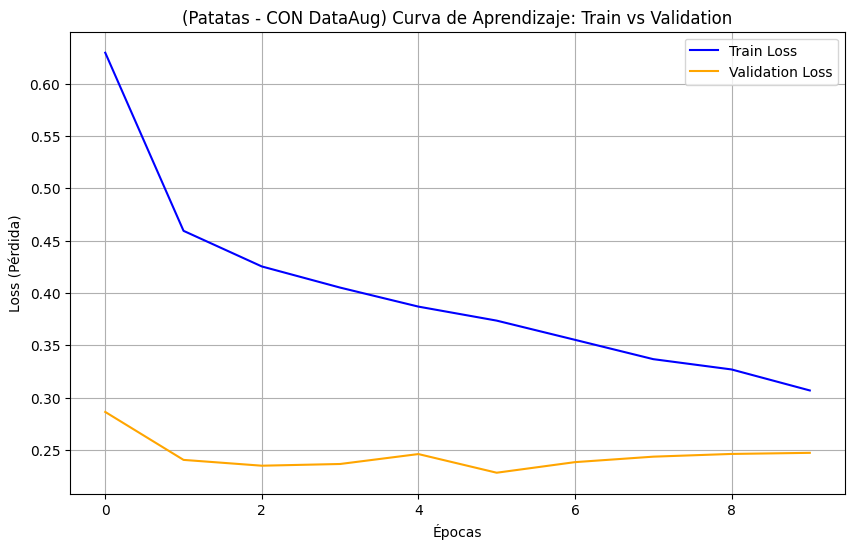

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.xlabel('Épocas')
plt.ylabel('Loss (Pérdida)')
plt.title('(Patatas - CON DataAug) Curva de Aprendizaje: Train vs Validation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 1. Definir ruta al conjunto de test
test_dir_Patatas_DataAug = "/content/Potatoes_leaf-diseases-3/test"
test_ann_Patatas_DataAug = "/content/Potatoes_leaf-diseases-3/test/_annotations.coco.json"

# 2. Crear Dataset y DataLoader de Test
dataset_test_Patatas_DataAug = RoboflowCocoDataset(test_dir_Patatas_DataAug, test_ann_Patatas_DataAug)
test_loader_Patatas_DataAug = torch.utils.data.DataLoader(
    dataset_test_Patatas_DataAug,
    batch_size=32,  # Igual que en el conjunto de evaluacion, puede ser el doble que en entrenamiento, porque no hay backprop
    shuffle=False,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

# 3. Lista de nombres de clases para el reporte (excluyendo background id 0)
mis_clases = ["early bright", "healthy", "late bright"]

# Ver los resultados en TRAIN y en TEST para ver si hay overfitting
print("\n--- TRAIN (Patatas - CON DataAug) ---")
metrics_train = evaluate_model(modelo_Patatas_DataAug, train_loader_Patatas_DataAug, device, class_names=mis_clases)

print("\n--- TEST (Patatas - CON DataAug) ---")
metrics_test = evaluate_model(modelo_Patatas_DataAug, test_loader_Patatas_DataAug, device, class_names=mis_clases)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

--- TRAIN (Patatas - CON DataAug) ---


Evaluando...: 100%|██████████| 115/115 [02:17<00:00,  1.20s/it]



Métricas Generales:
mAP (50-95): 0.6769
mAP (50):    0.9103
mAR (Recall):0.7629
----------------------------------------
Desglose por Clase (mAP 50-95):
early bright   : 0.5534
healthy        : 0.8912
late bright    : 0.5860


--- TEST (Patatas - CON DataAug) ---


Evaluando...: 100%|██████████| 4/4 [00:07<00:00,  1.97s/it]



Métricas Generales:
mAP (50-95): 0.5054
mAP (50):    0.7279
mAR (Recall):0.6578
----------------------------------------
Desglose por Clase (mAP 50-95):
early bright   : 0.4156
healthy        : 0.8853
late bright    : 0.2152

